In [61]:
import numpy as np
import pandas as pd
from tqdm import trange
import matplotlib.pyplot as plt
from collections import defaultdict

In [62]:
ALGORITHMS = ["asp_test_results", "hagen_test_results"]
KB_SIZES = [25, 50, 75,100,125, 150,175,200,225,250,275,300,325]
N_TRIALS = 100

In [63]:
def simulate_time(algo: str, kb_size: int) -> float:
    if algo == "ASP":
        return (2 * kb_size)  ** 2 + 10 + np.random.random() * 100000
    else:
        return kb_size ** 2 + np.random.random() * 50000

In [64]:
rows = []

for algo in ALGORITHMS:
    for kb_size in KB_SIZES:
        filename = f"{algo}/ranked_{kb_size}.txt"
        with open(filename) as file:
            results = file.readlines()
        count = 1
        for trial_idx in results:
            time = trial_idx.replace("\n","")
            rows.append({
                "algorithm": algo,
                "kb_size": kb_size,
                "trial_number": count, 
                "trial_time": float(time)
            })
            count+=1
        

df = pd.DataFrame(rows)

In [65]:
df

,algorithm,kb_size,trial_number,trial_time
0,asp_test_results,25,1,0.009
1,asp_test_results,25,2,0.002
2,asp_test_results,25,3,0.002
3,asp_test_results,25,4,0.002
4,asp_test_results,25,5,0.002
...,...,...,...,...
51982,hagen_test_results,325,1995,0.122
51983,hagen_test_results,325,1996,0.139
51984,hagen_test_results,325,1997,0.150
51985,hagen_test_results,325,1998,0.115


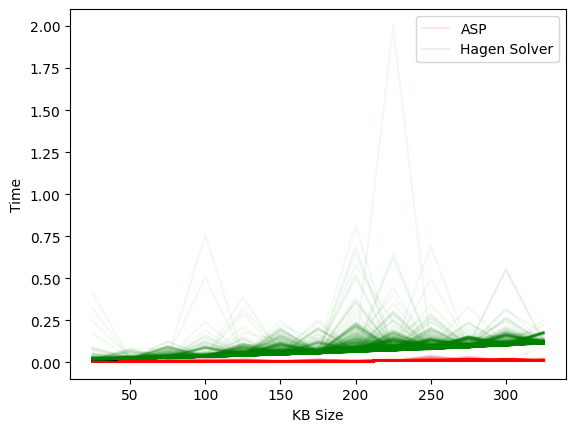

In [66]:
asp_labelled = False
h_thing_labelled = False
r_thing_labelled = False
for (algo, _), df_t in df.groupby(["algorithm", "trial_number"]):
    colour = 'r' if algo == 'asp_test_results' else 'g'
    if algo == 'asp_test_results':
        if not asp_labelled:
            plt.plot(df_t.kb_size, df_t.trial_time, alpha=0.1, c=colour, label="ASP")
            asp_labelled = True
        else:
            plt.plot(df_t.kb_size, df_t.trial_time, alpha=0.05, c=colour)
    elif algo == 'hagen_test_results':
        if not h_thing_labelled:
            plt.plot(df_t.kb_size, df_t.trial_time, alpha=0.1, c=colour, label="Hagen Solver")
            h_thing_labelled = True
        else:
            plt.plot(df_t.kb_size, df_t.trial_time, alpha=0.05, c=colour)

plt.xlabel("KB Size")
plt.ylabel("Time")
plt.legend()
plt.show()


In [67]:
def get_bootstrap_ci_for_mean(
    dataset: np.ndarray, n_samples: int = 10000, alpha=0.01
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    bootstrap_estimates = _get_bootstrap_mean_estimates(dataset, n_samples)
    mean = np.mean(dataset, axis=0)
    quatiles = np.quantile(bootstrap_estimates, [alpha, 1 - alpha], axis=0)
    return mean, quatiles[0], quatiles[1]


def _get_bootstrap_mean_estimates(
    dataset: np.ndarray, n_samples: int = 10000
) -> np.ndarray:
    means = []

    for _ in trange(n_samples):
        sample_idx = np.random.choice(
            np.arange(len(dataset)), size=len(dataset), replace=True
        )
        samples = dataset[sample_idx]
        mean_estimate = np.mean(samples, axis=0)
        means.append(mean_estimate)
    return np.array(means)


100%|██████████| 10000/10000 [00:01<00:00, 9706.29it/s]


asp_test_results
[0.002175  0.0030635 0.003822  0.004307  0.005293  0.0060185 0.00661
 0.007019  0.0080475 0.00943   0.0106005 0.0109785 0.011189 ]
[0.002136   0.003038   0.0037545  0.004232   0.0051865  0.00601
 0.00657049 0.007013   0.008017   0.0093385  0.01050349 0.010905
 0.01112   ]


100%|██████████| 10000/10000 [00:01<00:00, 9136.99it/s]


hagen_test_results
[0.01829365 0.02316058 0.03037369 0.03746923 0.04665133 0.05593647
 0.06117109 0.07708054 0.08464282 0.0904087  0.09846673 0.11121361
 0.12035668]
[0.0177904  0.02298499 0.03005    0.03664031 0.04601401 0.05519208
 0.06060129 0.07540618 0.08272484 0.08941721 0.09790443 0.11033917
 0.11991846]


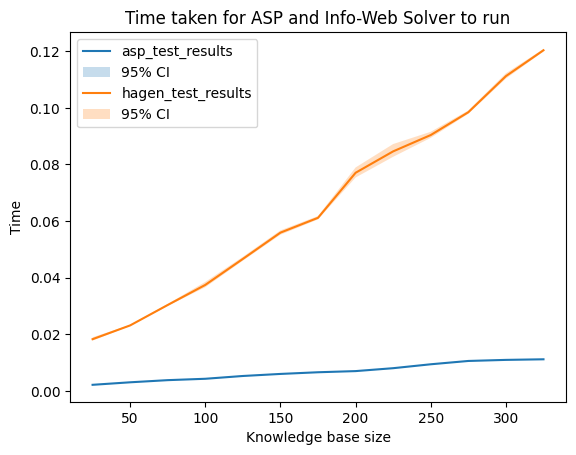

In [68]:
import csv
from collections import defaultdict


all_trial_times = defaultdict(list)
knowledge_base_size = []
results = {}
for (algo, kb_size), df_t in df.groupby(["algorithm", "trial_number"]):
    knowledge_base_size = df_t.kb_size.values
    all_trial_times[algo].append(df_t.trial_time.values)

for algo, trial_times in all_trial_times.items():
    mean, lower, upper = get_bootstrap_ci_for_mean(np.array(trial_times), alpha=0.025)
    results[algo] = (mean, lower, upper)
    print(algo)
    print(mean)
    print(lower)
    plt.plot(KB_SIZES, mean, label=algo)
    plt.fill_between(KB_SIZES, lower, upper, alpha=0.25, label='95% CI')
with open("new_results_1.csv", "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    
    # Write header
    writer.writerow([
        "knowledge_bases",
        "asp_mean", "asp_lower", "asp_upper",
        "hagen_mean", "hagen_lower", "hagen_upper"
    ])
    
    # Iterate through knowledge base sizes
    for i, kb_size in enumerate(range(25, 325, 25)):
        asp_mean, asp_lower, asp_upper = results["asp_test_results"]
        hagen_mean, hagen_lower, hagen_upper = results["hagen_test_results"]
        
        writer.writerow([
            kb_size,
            asp_mean[i], asp_lower[i], asp_upper[i],
            hagen_mean[i], hagen_lower[i], hagen_upper[i],
        ])

plt.xlabel("Knowledge base size")
plt.ylabel("Time")
plt.title("Time taken for ASP and Info-Web Solver to run")
plt.legend()
plt.show()




In [69]:
import csv
from collections import defaultdict
import numpy as np

# Store the results for the CSV
results = {
    "knowledge_bases": KB_SIZES,
    "asp_mean": [],
    "asp_lower": [],
    "asp_upper": [],
    "h_mean": [],
    "h_lower": [],
    "h_upper": [],
}

# Clear and repopulate all_trial_times correctly
all_trial_times = defaultdict(list)

# Group correctly by algorithm and kb_size
for (algo, kb_size), df_t in df.groupby(["algorithm", "kb_size"]):
    all_trial_times[algo].append((kb_size, df_t.trial_time.values))

for algo, trials in all_trial_times.items():
    # Sort by knowledge base size to align with KB_SIZES
    trials.sort(key=lambda x: x[0])
    trial_times_only = [t[1] for t in trials]  # just keep the np.arrays of times

    mean, lower, upper = get_bootstrap_ci_for_mean(np.array(trial_times_only), alpha=0.025)
    print(mean)
    print(lower)
    print(upper)
    if "asp" in algo.lower():
        results["asp_mean"] = mean
        results["asp_lower"] = lower
        results["asp_upper"] = upper
    elif "hagen" in algo.lower() or "h" in algo.lower():  # customize this for your algorithm names
        results["h_mean"] = mean
        results["h_lower"] = lower
        results["h_upper"] = upper
i = 0
for knowledge_base in range(25,350,25):
    with open("new_results.csv", "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        # Write header
        writer.writerow([
            "knowledge_bases", 
            "asp_mean", "asp_lower", "asp_upper", 
            "h_mean", "h_lower", "h_upper"
        ])
        writer.writerow([
            knowledge_base,
            results["asp_mean"][i], results["asp_lower"][i], results["asp_upper"][i],
            results["h_mean"][i], results["h_lower"][i], results["h_upper"][i],
        ])
        i+=1
        
        

# Write to CSV
with open("trial_results.csv", "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    # Write header
    writer.writerow([
        "knowledge_bases", 
        "asp_mean", "asp_lower", "asp_upper", 
        "h_mean", "h_lower", "h_upper"
    ])
    # Write rows
    for i in range(len(KB_SIZES)):
        writer.writerow([
            results["knowledge_bases"][i],
            results["asp_mean"][i], results["asp_lower"][i], results["asp_upper"][i],
            results["h_mean"][i], results["h_lower"][i], results["h_upper"][i],
        ])


100%|██████████| 10000/10000 [00:00<00:00, 18720.38it/s]


[0.00792308 0.00661538 0.00653846 ... 0.00692308 0.00684615 0.00684615]
[0.00646154 0.00507692 0.005      ... 0.00538462 0.00530769 0.00538462]
[0.00953846 0.00823077 0.00815385 ... 0.00869231 0.00853846 0.00846154]


100%|██████████| 10000/10000 [00:00<00:00, 15806.36it/s]


[0.06961538 0.07938462 0.06807692 ... 0.11492308 0.07615385 0.06707692]
[0.05430769 0.05069038 0.04769038 ... 0.05261538 0.05315192 0.05015385]
[0.08461538 0.11430769 0.09192308 ... 0.21930769 0.10107692 0.08415385]


100%|██████████| 10000/10000 [00:01<00:00, 9530.14it/s]


asp_test_results
[0.002175  0.0030635 0.003822  0.004307  0.005293  0.0060185 0.00661
 0.007019  0.0080475 0.00943   0.0106005 0.0109785 0.011189 ]
[0.0021355  0.003038   0.0037555  0.0042335  0.00518799 0.0060095
 0.0065705  0.007013   0.008017   0.00933999 0.0105045  0.01090449
 0.011121  ]


100%|██████████| 10000/10000 [00:00<00:00, 10203.22it/s]


hagen_test_results
[0.01829365 0.02316058 0.03037369 0.03746923 0.04665133 0.05593647
 0.06117109 0.07708054 0.08464282 0.0904087  0.09846673 0.11121361
 0.12035668]
[0.01778839 0.02297999 0.03004152 0.0366438  0.0459925  0.05519357
 0.06061031 0.07539664 0.08271036 0.08941118 0.09789595 0.11035218
 0.11992095]
asp_test_results Regression: y = 0.00003x + 0.00133 (R² = 0.9891)
hagen_test_results Regression: y = 0.00035x + 0.00498 (R² = 0.9943)


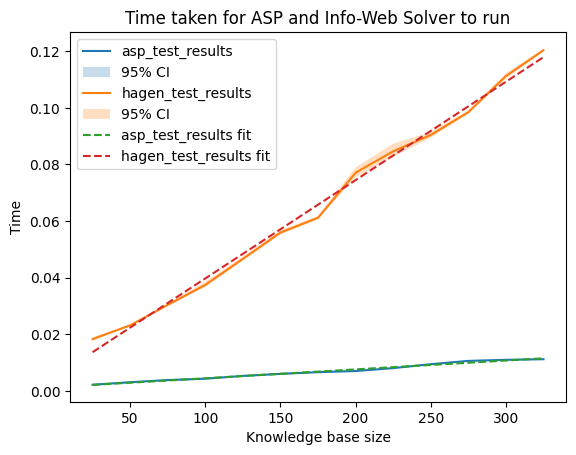

In [70]:
from scipy.stats import linregress

KB_SIZES = list(range(25, 350, 25))

all_trial_times = defaultdict(list)
knowledge_base_size = []
results = {}
for (algo, kb_size), df_t in df.groupby(["algorithm", "trial_number"]):
    knowledge_base_size = df_t.kb_size.values
    all_trial_times[algo].append(df_t.trial_time.values)

for algo, trial_times in all_trial_times.items():
    mean, lower, upper = get_bootstrap_ci_for_mean(np.array(trial_times), alpha=0.025)
    results[algo] = (mean, lower, upper)
    print(algo)
    print(mean)
    print(lower)
    plt.plot(KB_SIZES, mean, label=algo)
    plt.fill_between(KB_SIZES, lower, upper, alpha=0.25, label='95% CI')
for algo_name in results:
    mean, lower, upper = results[algo_name]  # <-- explicitly unpack here
    slope, intercept, r_value, p_value, std_err = linregress(KB_SIZES, mean)
    print(f"{algo_name} Regression: y = {slope:.5f}x + {intercept:.5f} (R² = {r_value**2:.4f})")

    # Generate regression line
    regression_line = [slope * x + intercept for x in KB_SIZES]
    plt.plot(KB_SIZES, regression_line, linestyle='--', label=f"{algo_name} fit")

# Continue with plot
plt.xlabel("Knowledge base size")
plt.ylabel("Time")
plt.title("Time taken for ASP and Info-Web Solver to run")
plt.legend()
plt.show()
